In [1]:
import sys
sys.path.append(r"D:\unsw\2023T3\COMP9517\group project\codes\elpv-dataset-master")
from utils.elpv_reader import load_dataset
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import torchvision.models as models
from torch.optim import Adam
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, LambdaLR, CosineAnnealingLR,ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
#载入数据集
images, probs, types = load_dataset()
# a) Resize images
base_transform = transforms.Compose([
    # Convert np array to PIL Image
    # 转换np数组为PIL图像
    transforms.ToPILImage(), 
    # Resize images to match ResNet input
    # 调整图像大小以匹配ResNet输入
    transforms.Resize((224, 224)), 
    # Convert grayscale to RGB
    # 转换灰度为RGB以匹配ResNet输入
    transforms.Grayscale(num_output_channels=3),  
    # Convert to Tensor
    # 转换为张量
    transforms.ToTensor(), 
    # Normalize to match ResNet preprocessing
    # 标准化以匹配ResNet预处理
    transforms.Normalize(mean=[0.59685254, 0.59685254, 0.59685254], std=[0.16043035, 0.16043035, 0.16043035])  
])
# b) Data Augmentation
# 数据增强
train_transform = transforms.Compose([
    # Convert np array to PIL Image
    # 转换np数组为PIL图像
    transforms.ToPILImage(), 
    # Randomly crop images to 224 x 224
    # 随机裁剪图像为224 x 224
    transforms.RandomResizedCrop(224),
    # flips and color jitter
    # 随机水平翻转
    transforms.RandomHorizontalFlip(p=0.5),
    # 随机垂直翻转
    transforms.RandomVerticalFlip(p=0.5),
    # 改变亮度和对比度
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # Random affine transformation
    # 仿射变换
    transforms.RandomAffine(degrees=(-3, 3), translate=(0.02, 0.02)), 
    transforms.RandomResizedCrop((300, 300), scale=(0.98, 1.0), ratio=(1.0, 1.0)),
    # Convert grayscale to RGB
    # 转换灰度为RGB以匹配ResNet输入
    transforms.Grayscale(num_output_channels=3),  
    # Convert to Tensor
    # 转换为张量
    transforms.ToTensor(), 
    # Normalize to match ResNet preprocessing
    # 标准化以匹配ResNet预处理
    transforms.Normalize(mean=[0.59685254, 0.59685254, 0.59685254], std=[0.16043035, 0.16043035, 0.16043035]) 

])
# c) Pre process of solar cell types
# transfer types to one-hot encoding
# 处理太阳能电池类型，将其转化为one-hot编码
types_encoded = []
for t in types:
    if t == "mono":
        types_encoded.append(np.array([1,0]))
    else:
        types_encoded.append(np.array([0,1]))

types_encoded_array = np.array(types_encoded)

types_tensor = torch.tensor(types_encoded_array, dtype=torch.float32)
# d) transfer probs to classes
# 将概率转换为类别
def convert_probs_to_classes(probs):
    """
    Converts probability labels to class labels.
    0% probability -> Class 0
    33.33333% probability -> Class 1
    66.66666% probability -> Class 2
    100% probability -> Class 3
    """
    # 初始化一个空列表来存储类别标签
    classes = []
    # 遍历所有的概率，将它们映射到类别
    for prob in probs:
        if prob == 0 :
            classes.append(0)  # 属于类别0
        elif prob <= 0.34:
            classes.append(1)  # 属于类别1
        elif prob <= 0.67:
            classes.append(2)  # 属于类别2
        else:
            classes.append(3)  # 属于类别3
    # 将列表转换为NumPy数组
    return np.array(classes)
# e) Split dataset
# 划分数据集
# 先分离出测试集
X_temp, X_test, X_type_temp, X_type_test, y_temp, y_test = train_test_split(
    images, types_tensor, probs, test_size=0.24, random_state=42)

# 再将剩余数据分成训练集和验证集
X_train, X_val, X_type_train, X_type_val, y_train, y_val = train_test_split(
    X_temp, X_type_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.80 = 0.20

# 应用特征增强到训练集
transferred_images_train = [base_transform(image) for image in X_train]
X_train_transformed = torch.stack(transferred_images_train)

# 应用普通转换到测试集和验证集
transferred_images_test = [base_transform(image) for image in X_test]
X_test_transformed = torch.stack(transferred_images_test)

transferred_images_val = [base_transform(image) for image in X_val]
X_val_transformed = torch.stack(transferred_images_val)

# 转换概率为类别标签
y_train_classes = torch.tensor(convert_probs_to_classes(y_train), dtype=torch.long)
y_test_classes = torch.tensor(convert_probs_to_classes(y_test), dtype=torch.long)
y_val_classes = torch.tensor(convert_probs_to_classes(y_val), dtype=torch.long)

def print_class_counts(classes, dataset_name):
    class_counts = Counter(classes.numpy())
    print(f"\n{dataset_name} set class counts:")
    for class_label, count in class_counts.items():
        print(f"Class {class_label}: {count}")


# 打印各数据集的类别数量
print_class_counts(y_train_classes, "Training")
print_class_counts(y_test_classes, "Testing")
print_class_counts(y_val_classes, "Validation")




Training set class counts:
Class 0: 856
Class 3: 418
Class 1: 172
Class 2: 49

Testing set class counts:
Class 3: 173
Class 1: 70
Class 0: 356
Class 2: 31

Validation set class counts:
Class 3: 124
Class 0: 296
Class 1: 53
Class 2: 26


In [2]:
# 分离测试集中的单晶和多晶电池
mono_indices = [i for i, t in enumerate(X_type_test) if t[0] == 1]  # 单晶电池
poly_indices = [i for i, t in enumerate(X_type_test) if t[1] == 1]  # 多晶电池

mono_images_test = X_test[mono_indices]
poly_images_test = X_test[poly_indices]

mono_probs_test = y_test[mono_indices]
poly_probs_test = y_test[poly_indices]

# 将概率转换为类别
mono_classes_test = convert_probs_to_classes(mono_probs_test)
poly_classes_test = convert_probs_to_classes(poly_probs_test)

# 应用基本转换
transformed_mono_images_test = [train_transform(image) for image in mono_images_test]
transformed_poly_images_test = [base_transform(image) for image in poly_images_test]

mono_images_test_tensor = torch.stack(transformed_mono_images_test)
poly_images_test_tensor = torch.stack(transformed_poly_images_test)

mono_classes_test_tensor = torch.tensor(mono_classes_test, dtype=torch.long)
poly_classes_test_tensor = torch.tensor(poly_classes_test, dtype=torch.long)

# 为单晶和多晶电池创建类型张量
mono_types_test_tensor = torch.ones(len(mono_images_test), 2)  # 全为 [1, 0]
poly_types_test_tensor = torch.zeros(len(poly_images_test), 2)  # 全为 [0, 1]
mono_types_test_tensor[:, 1] = 0
poly_types_test_tensor[:, 0] = 1

# 创建 DataLoader
batch_size = 16
mono_test_loader = DataLoader(TensorDataset(mono_images_test_tensor, mono_types_test_tensor, mono_classes_test_tensor), batch_size=batch_size, shuffle=False)
poly_test_loader = DataLoader(TensorDataset(poly_images_test_tensor, poly_types_test_tensor, poly_classes_test_tensor), batch_size=batch_size, shuffle=False)

# 定义一个函数来打印类别的计数
def print_class_distribution(classes, dataset_type):
    class_counts = Counter(classes)
    print(f"Class distribution in {dataset_type} dataset:")
    for class_label, count in class_counts.items():
        print(f"Class {class_label}: {count}")

# 检查单晶数据集中的类别分布
print_class_distribution(mono_classes_test, "Mono")
print('Total Mono: ',139+80+25+18)

# 检查多晶数据集中的类别分布
print_class_distribution(poly_classes_test, "Poly")
print('Total Poly: ',  93+45+217+13)



Class distribution in Mono dataset:
Class 0: 139
Class 3: 80
Class 1: 25
Class 2: 18
Total Mono:  262
Class distribution in Poly dataset:
Class 3: 93
Class 1: 45
Class 0: 217
Class 2: 13
Total Poly:  368


In [3]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        # 加载ResNet18模型
        self.resnet = models.resnet18(pretrained=True)
        # 替换最后一层来适应输出类别
        # +2是加上了太阳能电池类型的one-hot编码。4是类别数量
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features+2, 4)
        self.leakyrelu = nn.LeakyReLU()
    
    def forward(self, x_img, x_types):
        # 从图像中提取特征
        # 卷积层，用于提取图像特征
        x_img = self.resnet.conv1(x_img)
        # 批量归一化层
        x_img = self.resnet.bn1(x_img)
        # 激活函数
        x_img = self.leakyrelu(x_img)
        # 最大池化层，减少特征维度
        x_img = self.resnet.maxpool(x_img)
        # 4个残差层，每一层都包含多个跳跃连接，允许梯度直接流动
        x_img = self.resnet.layer1(x_img)
        x_img = self.resnet.layer2(x_img)
        x_img = self.resnet.layer3(x_img)
        x_img = self.resnet.layer4(x_img)
        # 平均池化层，减少特征维度
        x_img = self.resnet.avgpool(x_img)
        # 将图像特征展平到一维向量
        x_img = torch.flatten(x_img, 1)

        #将图像特征和太阳能电池类型的one-hot编码连接起来
        x = torch.cat((x_img, x_types), dim=1)
        # 在全连接层之前应用 Dropout
        x = F.dropout(x, p=0.3, training=self.training)
        # 最后一层全连接层，把合并后的特征向量转换为类别输出
        x = self.resnet.fc(x)
        return x


In [4]:
# 调整类别权重：
train_class_counts = [1136, 222, 75, 535]
# 计算每个类别的权重（类别频率的倒数）
weights = [1.0/count for count in train_class_counts]
# 标准化权重，使得它们的和为1
total = sum(weights)
weights = [weight/total for weight in weights]
class_weights = torch.tensor(weights, dtype=torch.float)
if torch.cuda.is_available():
    class_weights = class_weights.cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [5]:
# 实例化模型
model = ResNet()
if torch.cuda.is_available():
    model.cuda()
    criterion.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# 优化器和学习率调度器
'''
Adam优化器,MultistepLR学习率调度器
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = MultiStepLR(optimizer, milestones=[10, 20, 30], gamma=0.1)
'''
'''
SGD优化器,MultistepLR学习率调度器
optim = t.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = MultiStepLR(optim, milestones=[10, 20 , 30 , 40], gamma=0.1)
scheduler2 = t.optim.lr_scheduler.MultiStepLR(optim, milestones=[60, 80, 100, 130], gamma=0.5)
'''
# 70%->lr=0.00001
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0.00035)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True, threshold=0.0005, threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# 设置训练epoch数量
# SGD_num_epochs=20
Adam_num_epochs=50


In [7]:
# 设置验证集函数
def validate_model(model, val_loader, criterion, device):
    model.eval()  # 设置为评估模式
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # 关闭梯度计算
        for inputs, types, labels in val_loader:
            inputs, types, labels = inputs.to(device), types.to(device), labels.to(device)
            
            outputs = model(inputs, types)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


In [8]:
# 设置早停参数
patience = 11 # 在停止前可以容忍的没有改善的周期数
min_improvement = 0.003  # 视为改善的最小损失减少
best_loss = float('inf')
epochs_no_improve = 0

In [9]:
#训练过程
train_dataset = TensorDataset(X_train_transformed, X_type_train,y_train_classes)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val_transformed, X_type_val,y_val_classes)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = TensorDataset(X_test_transformed, X_type_test,y_test_classes)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#for epoch in range(SGD_num_epochs):
for epoch in range(Adam_num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, types, labels in train_loader:
        # If GPU is available, move the data to the GPU for faster computation
        if torch.cuda.is_available():
            inputs, types, labels = inputs.cuda(), types.cuda(), labels.cuda()

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs, types)
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass to calculate the weight gradients
        optimizer.step()  # Update the weights

        running_loss += loss.item() * inputs.size(0)  # Total loss for the batch
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
        total_predictions += labels.size(0)

    epoch_loss = running_loss / total_predictions  # Average loss for the epoch
    epoch_acc = correct_predictions / total_predictions  # Accuracy for the epoch
    model.eval()  # 设置为评估模式
    val_running_loss = 0.0
    val_total_predictions = 0

    with torch.no_grad():
        for val_inputs, val_types, val_labels in val_loader:
            if torch.cuda.is_available():
                val_inputs, val_types, val_labels = val_inputs.cuda(), val_types.cuda(), val_labels.cuda()

            val_outputs = model(val_inputs, val_types)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_total_predictions += val_labels.size(0)

    val_loss = val_running_loss / val_total_predictions

    # 检查是否有改善，并据此更新早停计数器
    if val_loss + min_improvement < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # 如果连续多个周期没有改善，则提前停止
    if epochs_no_improve == patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break
    # Step the scheduler
    # scheduler.step()
    #scheduler1.step()
    #scheduler2.step()
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    #print(f'Epoch {epoch+1}/{SGD_num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    print(f'Epoch {epoch+1}/{Adam_num_epochs} - Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')
    print(f'Epoch {epoch+1}/{Adam_num_epochs} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch 1/50 - Training Loss: 1.2606, Training Accuracy: 0.4803
Epoch 1/50 - Validation Loss: 1.2466, Validation Accuracy: 0.4589
Epoch 2/50 - Training Loss: 0.9780, Training Accuracy: 0.6020
Epoch 2/50 - Validation Loss: 1.2195, Validation Accuracy: 0.6132
Epoch 3/50 - Training Loss: 0.7631, Training Accuracy: 0.6950
Epoch 3/50 - Validation Loss: 1.5373, Validation Accuracy: 0.6834
Epoch 4/50 - Training Loss: 0.5676, Training Accuracy: 0.7726
Epoch 4/50 - Validation Loss: 1.4091, Validation Accuracy: 0.6132
Epoch 5/50 - Training Loss: 0.4424, Training Accuracy: 0.8187
Epoch 5/50 - Validation Loss: 1.6823, Validation Accuracy: 0.6253
Epoch 00006: reducing learning rate of group 0 to 3.0000e-05.
Epoch 6/50 - Training Loss: 0.3526, Training Accuracy: 0.8595
Epoch 6/50 - Validation Loss: 1.8020, Validation Accuracy: 0.6974
Epoch 7/50 - Training Loss: 0.1994, Training Accuracy: 0.9164
Epoch 7/50 - Validation Loss: 1.6095, Validation Accuracy: 0.7295
Epoch 8/50 - Training Loss: 0.1076, Traini

In [10]:
# Assuming you want to use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the appropriate device

y_true = y_test_classes.numpy()
y_pred_list = []

model.eval()
with torch.no_grad():
    for images, types, labels in test_loader:
        images, types = images.to(device), types.to(device)
        outputs = model(images, types)
        _, predicted = torch.max(outputs, 1)
        y_pred_list.append(predicted.cpu().numpy())

y_pred = np.concatenate(y_pred_list)

# 计算F1分数
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred, normalize=True)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Accuracy: 0.7666666666666667
Precision: 0.7538050826971913
F1 Score: 0.7553914282816269


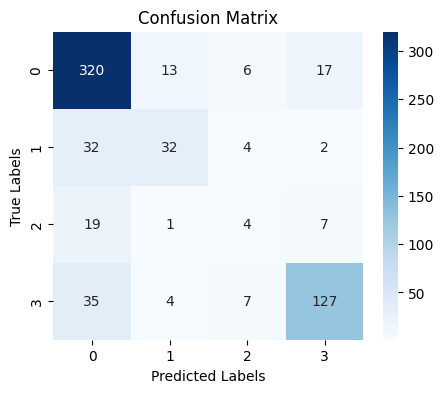

[[320  13   6  17]
 [ 32  32   4   2]
 [ 19   1   4   7]
 [ 35   4   7 127]]


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(conf_matrix)

For mono PV, Loss = 1.9595, Accuracy = 0.4809, Precision=0.5767, F1 Score = 0.4343
For poly PV: Loss = 1.3659, Accuracy = 0.7663, Precision=0.7553, F1 Score = 0.7554


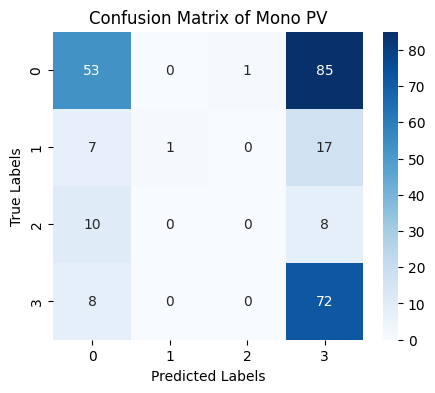

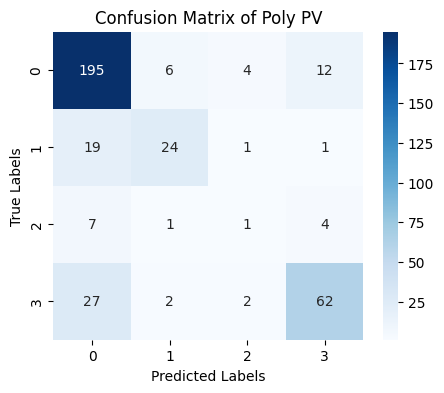

In [12]:
# 设置验证集函数
def validate_model2(model, val_loader, criterion, device):
    model.eval()  # 设置为评估模式
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # 关闭梯度计算
        for inputs, types, labels in val_loader:
            inputs, types, labels = inputs.to(device), types.to(device), labels.to(device)

            outputs = model(inputs, types)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy, all_predictions, all_labels
# 评估模型
model.eval()  # 设置为评估模式
# 测试单晶电池
mono_loss, mono_accuracy, mono_predictions, mono_labels = validate_model2(model, mono_test_loader, criterion, device)
mono_precision = precision_score(mono_labels, mono_predictions, average='weighted')
mono_f1 = f1_score(mono_labels, mono_predictions, average='weighted')

# 测试多晶电池
poly_loss, poly_accuracy, poly_predictions, poly_labels = validate_model2(model, poly_test_loader, criterion, device)
poly_precision = precision_score(poly_labels, poly_predictions, average='weighted')
poly_f1 = f1_score(poly_labels, poly_predictions, average='weighted')

print("For mono PV, Loss = {:.4f}, Accuracy = {:.4f}, Precision={:.4f}, F1 Score = {:.4f}".format(mono_loss, mono_accuracy, mono_precision, mono_f1))
print("For poly PV: Loss = {:.4f}, Accuracy = {:.4f}, Precision={:.4f}, F1 Score = {:.4f}".format(poly_loss, poly_accuracy, poly_precision, poly_f1))
conf_matrix_mono = confusion_matrix(mono_labels, mono_predictions)
conf_matrix_poly = confusion_matrix(poly_labels, poly_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_mono, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Mono PV')
plt.show()
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_poly, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Poly PV')
plt.show()


Correctly classified images:


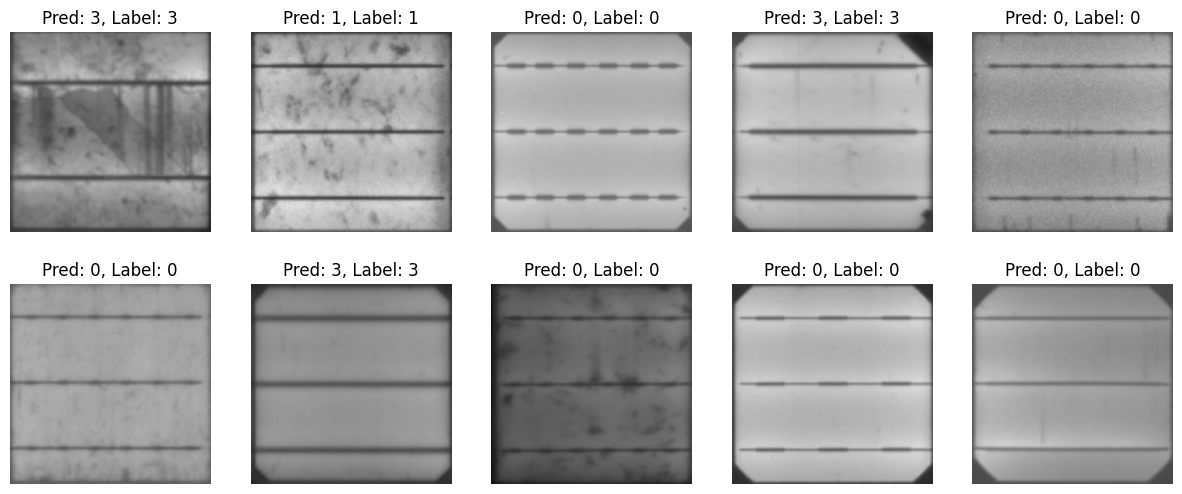

Incorrectly classified images:


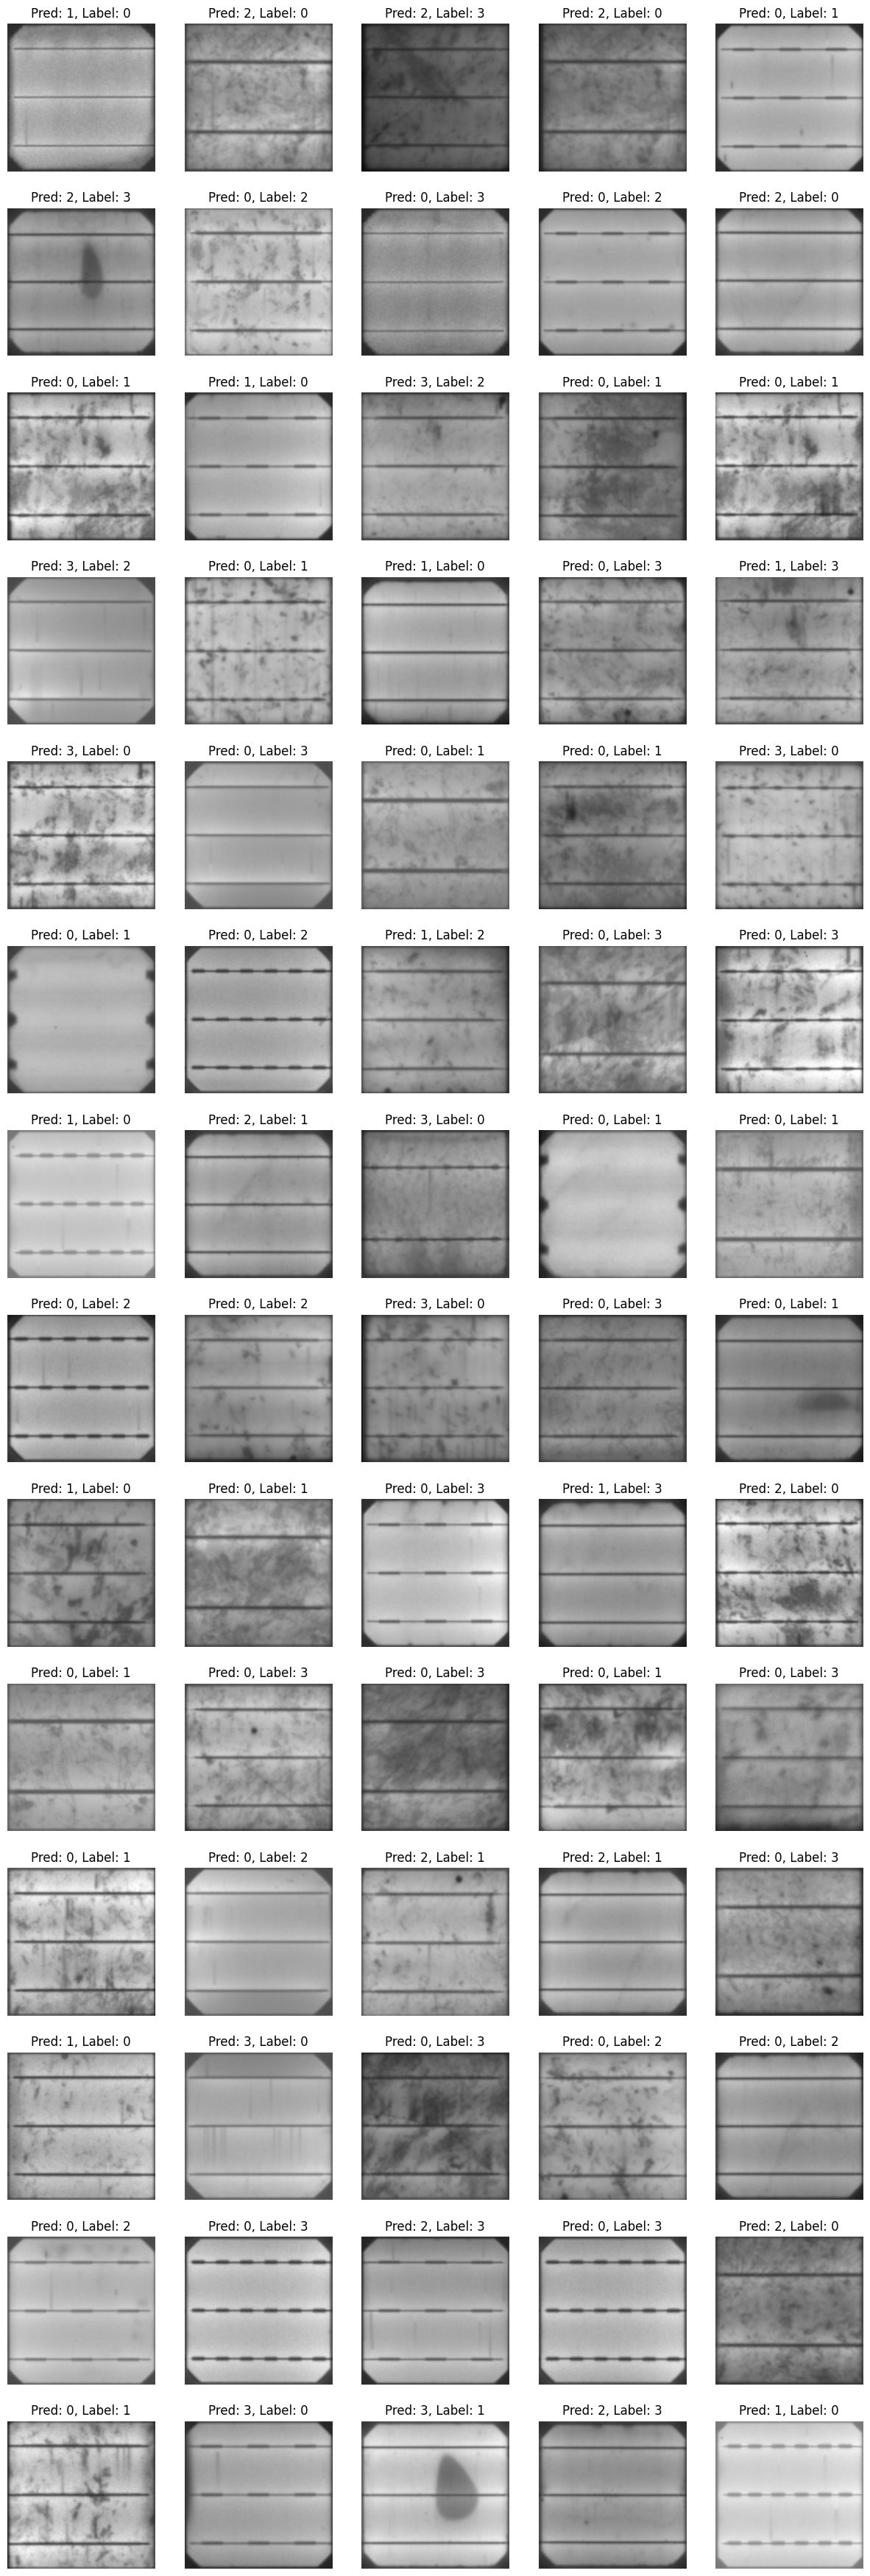

In [13]:
def visualize_predictions(loader, model, device, num_correct=10, num_incorrect=70):
    model.eval()
    correct_images = []
    incorrect_images = []

    with torch.no_grad():
        for inputs, types, labels in loader:
            inputs, types, labels = inputs.to(device), types.to(device), labels.to(device)
            outputs = model(inputs, types)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if len(correct_images) < num_correct and predicted[i] == labels[i]:
                    correct_images.append((inputs[i].cpu(), predicted[i], labels[i]))
                elif len(incorrect_images) < num_incorrect and predicted[i] != labels[i]:
                    incorrect_images.append((inputs[i].cpu(), predicted[i], labels[i]))

            if len(correct_images) >= num_correct and len(incorrect_images) >= num_incorrect:
                break

    # 将图像从Tensor转换为NumPy，并进行可视化
    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.59685254, 0.59685254, 0.59685254])
        std = np.array([0.16043035, 0.16043035, 0.16043035])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.axis('off')  # 移除坐标轴

    # 显示正确分类的图像
    print("Correctly classified images:")
    plt.figure(figsize=(15, 6))
    for i, (img, pred, label) in enumerate(correct_images):
        plt.subplot(2, 5, i + 1)
        imshow(img)
        plt.title(f"Pred: {pred}, Label: {label}")

    plt.show()

    # 显示错误分类的图像
    print("Incorrectly classified images:")
    plt.figure(figsize=(15, 45))  
    for i, (img, pred, label) in enumerate(incorrect_images):
        plt.subplot(14, 5, i + 1) 
        imshow(img)
        plt.title(f"Pred: {pred}, Label: {label}")

    plt.show()

# 调用函数
visualize_predictions(test_loader, model, device, num_correct=10, num_incorrect=70)
